## **Objetive**

## **Loading and Settings**

In [10]:
# Imports & Configuration
from pathlib import Path
import pandas as pd
import duckdb as db

con = db.connect()
DATA_DIR = Path('data/raw')
OUTPUT_FILE = Path('data/processed/stack.csv')

print(f'[CONFIG] DATA_DIR={DATA_DIR} | OUTPUT_FILE={OUTPUT_FILE}')

[CONFIG] DATA_DIR=data\raw | OUTPUT_FILE=data\processed\stack.csv


In [11]:
# Filesystem preparation

def ensure_output_dir(path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)


def list_csv_files(data_dir: Path) -> list[Path]:
    files = sorted(data_dir.glob('*.csv'))
    assert files, 'No CSV files found'
    return files


ensure_output_dir(OUTPUT_FILE)
files = list_csv_files(DATA_DIR)


for file in files:
    print(file)         

print(f'Total: {len(files)} CSV files found')

data\raw\2020 and before 2004970 rows.csv
data\raw\2021-2020 2018176 rows.csv
data\raw\2022-2021 1821488 rows.csv
data\raw\2023-2022 1772092 rows.csv
data\raw\2024-2023 1818726 rows.csv
data\raw\2025-2024 1884950 rows.csv
data\raw\2026-2025 1980801 rows.csv
Total: 7 CSV files found


In [12]:
# Scan each file schema
def scan_file(con: db.DuckDBPyConnection, file: Path):
    df = con.execute(f"""
        SELECT *
        FROM read_csv_auto('{file}', sample_size=-1)
    """).df()
    return set(df.columns), len(df)

schemas = []
row_counts = {}

for i, file in enumerate(files, start=1):
    cols, n_rows = scan_file(con, file)
    schemas.append(cols)
    row_counts[file.name] = n_rows

    print(
        f'[SCAN {i}/{len(files)}]\n'
        f'{file.name} | rows={n_rows} | cols={len(cols)}'
    )

print(f'[SCAN] Completed. Files scanned: {len(schemas)}')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[SCAN 1/7]
2020 and before 2004970 rows.csv | rows=2004970 | cols=39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[SCAN 2/7]
2021-2020 2018176 rows.csv | rows=2018176 | cols=39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[SCAN 3/7]
2022-2021 1821488 rows.csv | rows=1821488 | cols=39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[SCAN 4/7]
2023-2022 1772092 rows.csv | rows=1772092 | cols=39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[SCAN 5/7]
2024-2023 1818726 rows.csv | rows=1818726 | cols=39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[SCAN 6/7]
2025-2024 1884950 rows.csv | rows=1884950 | cols=39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[SCAN 7/7]
2026-2025 1980801 rows.csv | rows=1980801 | cols=39
[SCAN] Completed. Files scanned: 7


In [13]:
# Consolidate CSV files into a single stack.csv using common columns

def consolidate_csvs(files: list[Path], schemas: list[set], con, output: Path, row_counts: dict):

    # determine common columns
    common_fields = sorted(set.intersection(*schemas))
    assert common_fields, "No common columns across files"

    # build UNION ALL query
    union_query = " UNION ALL ".join(
        [
            f'SELECT {", ".join(common_fields)} '
            f'FROM read_csv_auto("{f}", SAMPLE_SIZE=-1)'
            for f in files
        ]
    )

    # export consolidated file
    con.execute(f"""
        COPY (
            {union_query}
        )
        TO '{output}'
        WITH (HEADER, DELIMITER ',');
    """)

    # sanity check
    total_rows = sum(row_counts.values())

    print(f"[EXPORT] file={output}")
    print(f"[EXPORT] rows={total_rows} | cols={len(common_fields)}")


consolidate_csvs(files, schemas, con, OUTPUT_FILE, row_counts)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

IOException: IO Error: Could not write file "data\processed\tmp_stack.csv" (error in WriteFile): Espaço insuficiente no disco.


## **Preprocessing**

KeyboardInterrupt: 

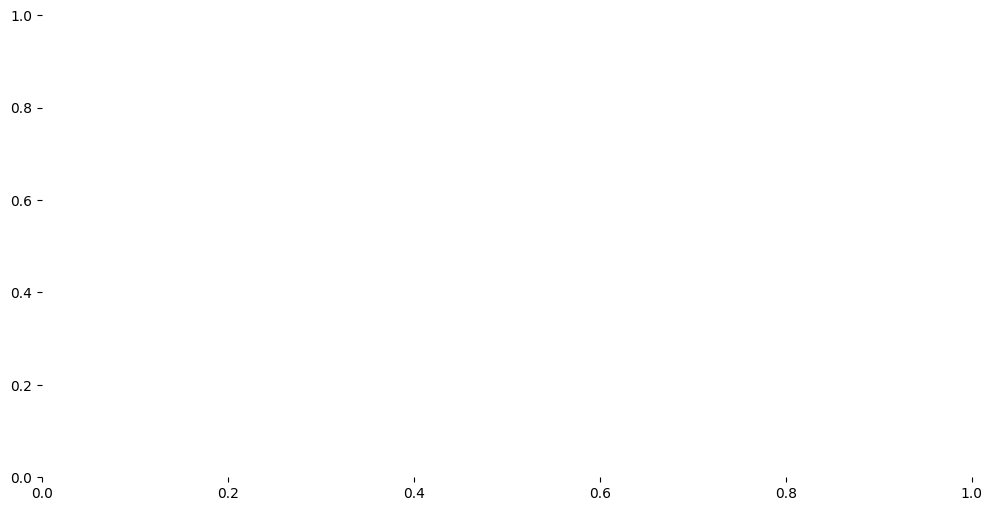

In [ ]:
# converting high missingness % to VARCHAR (preventing possible coalescing from read_csv_auto)
varchar_cols = {
    'LEGACY_SR_NUMBER': 'VARCHAR',
    'SANITATION_DIVISION_DAYS': 'VARCHAR',
    'PARENT_SR_NUMBER': 'VARCHAR',
    'ELECTRICAL_DISTRICT': 'VARCHAR',
    'CREATED_DEPARTMENT': 'VARCHAR',
    'CITY': 'VARCHAR',
    'STATE': 'VARCHAR',
    'ELECTRICITY_GRID': 'VARCHAR',
    'ZIP_CODE': 'VARCHAR'
}

df = con.execute(f"""
    SELECT *
    FROM read_csv_auto(
        '{OUTPUT_FILE}',
        sample_size=-1,
        timestampformat='%Y-%m-%d %H:%M:%S',
        types={varchar_cols})
    USING SAMPLE 10%
""").df()


(df.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)

In [ ]:
con.register("df_view", df)

con.execute("""
    COPY df_view
    TO 'data/processed/data.parquet'
    (FORMAT PARQUET)
""")